In [116]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# **Знакомство с данными**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [216]:
# создадим шаблон файла сабмита
submit_data = pd.read_csv('data/submission.csv')

In [166]:
# выгружаем 2 датасета: сразу создадим признак train_feat чтобы различать 2 массива в дальнейшем

hotels_train = pd.read_csv('data/hotels_train.csv')
hotels_train['train_feat'] = 1

# в hotels_test отсутствует целевой признак с оценками - при выгрузке добавим его и установим там значение 0
hotels_test = pd.read_csv('data/hotels_test.csv')
hotels_test['train_feat'] = 0
hotels_test['reviewer_score'] = 0

hotels = pd.concat([hotels_train, hotels_test], axis=0)
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,train_feat
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,1
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540,1
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060,1


In [167]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 128934
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Пропуски данных только в признаках lat/lng. 

Есть признак с датой, в формате object

# **Feature Engineering**

## 1. Преобразование существующих признаков

In [168]:
# 1.1 Переведем признак review_date в формат datetime

hotels['review_date']
hotels['review_date'] = pd.to_datetime(hotels['review_date'], errors='coerce')

In [169]:
# 1.2 Изменим признак tags, чтобы вместо строковой величины был адекватный список значений

hotels['tags'] = hotels['tags'].apply(lambda x: x[3:-3].split(" ', ' "))
hotels['tags'].head()

0    [Leisure trip, Couple, Studio Suite, Stayed 2 ...
1    [Business trip, Couple, Standard Double Room, ...
2    [Leisure trip, Solo traveler, Modern Double Ro...
3    [Leisure trip, Solo traveler, Standard Room wi...
4    [Business trip, Couple, Standard Double or Twi...
Name: tags, dtype: object

In [170]:
# посчитаем кол-во уникальных и самые популярные теги

tags_unique = {} # задаем пустой словарь для тегов

# функция для наполнения словаря тегами

def get_tags_count(row, tag_dict):
    
    for tag in row:
        if tag not in tag_dict:
            tag_dict[tag] = 1
        else:
            tag_dict[tag] +=1
    return tag_dict

# применяем на датасете

for row in hotels['tags']:
    get_tags_count(row, tags_unique)
    
print(f'Всего уникальных тегов: {len(tags_unique)}')

sorted(tags_unique.items(), key=lambda x: x[1], reverse=True) # отразим по убыванию самые популярные

Всего уникальных тегов: 2428


[('Leisure trip', 417778),
 ('Submitted from a mobile device', 307640),
 ('Couple', 252294),
 ('Stayed 1 night', 193645),
 ('Stayed 2 nights', 133937),
 ('Solo traveler', 108545),
 ('Stayed 3 nights', 95821),
 ('Business trip', 82939),
 ('Group', 65392),
 ('Family with young children', 61015),
 ('Stayed 4 nights', 47817),
 ('Double Room', 35207),
 ('Standard Double Room', 32248),
 ('Superior Double Room', 31393),
 ('Family with older children', 26349),
 ('Deluxe Double Room', 24823),
 ('Double or Twin Room', 22393),
 ('Stayed 5 nights', 20845),
 ('Standard Double or Twin Room', 17483),
 ('Classic Double Room', 16989),
 ('Superior Double or Twin Room', 13570),
 ('2 rooms', 12393),
 ('Stayed 6 nights', 9776),
 ('Standard Twin Room', 9745),
 ('Single Room', 9670),
 ('Twin Room', 8321),
 ('Stayed 7 nights', 7399),
 ('Executive Double Room', 6425),
 ('Classic Double or Twin Room', 6107),
 ('Superior Twin Room', 6064),
 ('Deluxe Double or Twin Room', 5998),
 ('Club Double Room', 5908),
 ('Qu

In [171]:
# 1.3 Переводим столбец с количеством дней с момента отзыва в числовой формат

hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: x.split()[0])

In [172]:
hotels['days_since_review'] = hotels['days_since_review'].astype(np.int64) # переводим из object в int64

In [174]:
# 1.4 Уберем пробелы в строке со страной рецензента в начале и в конце
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x[1:-1])

---

## 2. Создание новых признаков 

In [175]:
# 1. Выделим признак страны отеля из текстового признака адреса и с помощью этого столбца заполним пропуски в стобцах lat/lng

hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: x.split()[-1])
hotels['hotel_country'] = hotels['hotel_country'].apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x)
hotels['hotel_country'].value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: hotel_country, dtype: int64

In [176]:
# 1.1 Заполняем пропуски в столбца lat/lng

# проверяем в каких странах есть пропуски ширины/долготы

print(hotels[hotels['lat'].isnull()]['hotel_country'].value_counts())
print()
print(hotels[hotels['lng'].isnull()]['hotel_country'].value_counts()) 

# пропуски есть в 3х странах и точно совпадает количество, т.е. пропуски парные

Austria    2679
France      382
Spain       207
Name: hotel_country, dtype: int64

Austria    2679
France      382
Spain       207
Name: hotel_country, dtype: int64


In [177]:
# найдем моды координат для каждой страны

aus_mode = hotels[hotels['hotel_country'] == 'Austria'][['lat', 'lng']].mode()
fr_mode = hotels[hotels['hotel_country'] == 'France'][['lat', 'lng']].mode()
spain_mode = hotels[hotels['hotel_country'] == 'Spain'][['lat', 'lng']].mode()

# заполним пропуски данных модой для каждой страны 

# Австрия
mask = (hotels['hotel_country'] == 'Austria') & (hotels['lat'].isnull() == True) # создаем маску по стране + пропуски
aus_values = hotels.loc[mask, ['lat', 'lng']].fillna({'lat': aus_mode.iloc[0][0], # создаем промежуточный датафрейм с заполненными модами пропусками ширины/долготы для этой страны
                                                    'lng': aus_mode.iloc[0][1]}) # заменяем значения в оригинальном датафрейме промежуточныем
hotels.loc[mask, ['lat', 'lng']] = aus_values

# Франция
mask = (hotels['hotel_country'] == 'France') & (hotels['lat'].isnull() == True)
france_values = hotels.loc[mask, ['lat', 'lng']].fillna({'lat': fr_mode.iloc[0][0],
                                                        'lng': fr_mode.iloc[0][1]})
hotels.loc[mask, ['lat', 'lng']] = france_values

# Испания
mask = (hotels['hotel_country'] == 'Spain') & (hotels['lat'].isnull() == True)
spain_values = hotels.loc[mask, ['lat', 'lng']].fillna({'lat': spain_mode.iloc[0][0],
                                                        'lng': spain_mode.iloc[0][1]})
hotels.loc[mask, ['lat', 'lng']] = spain_values

In [178]:
# удостоверяемся, что пропуски ушли

hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 128934
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

In [179]:
# 2.1 Создадим бинарный признак совпадения страны рецензента и страны отеля.

hotels['same_country'] = hotels.apply(lambda x: 1 if x['reviewer_nationality'] == x['hotel_country'] else 0, axis=1)

In [180]:
# 2.2 Методом OHE закодируем отдельными признаками страны

countries_df = pd.get_dummies(hotels['hotel_country'], prefix='hotel_country')
hotels = pd.concat([hotels, countries_df], axis=1)

In [181]:
# 3. Методом OHE закодируем отдельными признаками самые популярные теги из словаря tags_unique
# отберем наиболее релевантные: кол-во ночей в отеле (до 7), тип поездки (деловая/отдых), количество персон (одиночный/пара/семья с детьми/группа)

# создадим список отобранных тегов
best_tags = ['Leisure trip', 'Business trip', 'Solo traveler', 'Couple', 'Family with young children', 'Group', 'Stayed 1 night', 'Stayed 2 nights', 'Stayed 3 nights', 'Stayed 4 nights', 'Stayed 5 nights', 'Stayed 6 nights', 'Stayed 7 nights']

# добавляем признаки в датафрейм
for tag in best_tags:
    hotels[tag] = hotels['tags'].apply(lambda x: 1 if tag in x else 0)
    
display(hotels.head())

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,Couple,Family with young children,Group,Stayed 1 night,Stayed 2 nights,Stayed 3 nights,Stayed 4 nights,Stayed 5 nights,Stayed 6 nights,Stayed 7 nights
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,1,0,0,0,1,0,0,0,0,0
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,1,0,0,1,0,0,0,0,0,0
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,...,0,0,0,0,0,1,0,0,0,0
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,2015-09-22,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,...,0,0,0,1,0,0,0,0,0,0
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,2016-03-05,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,...,1,0,0,0,0,0,0,0,1,0


In [220]:
# 4.1 Для анализа эмоционального тона отзыва сначала визуализируем зависмость средней оценки от кол-ва слов в отзыве

# создадим фильтр для тренировочной и тестовой части с оценками
train_mask = hotels['train_feat'] == 1
test_mask = hotels['train_feat'] == 0

negative_data = hotels[train_mask].groupby('review_total_negative_word_counts', as_index=False)['reviewer_score'].mean()
positive_data = hotels[train_mask].groupby('review_total_positive_word_counts', as_index=False)['reviewer_score'].mean()

In [196]:
import plotly
import plotly.express as px

negative_scatter = px.scatter(data_frame = negative_data,
                 x='review_total_negative_word_counts',
                 y='reviewer_score',
                 title='Зависимость средней оценки от кол-ва слов в отрицательном отзыве')

positive_scatter = px.scatter(data_frame = positive_data,
                 x='review_total_positive_word_counts',
                 y='reviewer_score',
                 title='Зависимость средней оценки от кол-ва слов в положительном отзыве')

negative_scatter.show()
positive_scatter.show()



**Выводы по графикам:** на графиках наблюдается 2 вида трендов. 
Отмечаем сильную линейную связь количества слов в повышением оценки и такую же для пары отрицательное количество слов/ухудшение оценки

Анализировать будем отзывы в строках, где значение количества слов в отзыве больше 0

In [267]:
# 4.2 Проанализируем эмоциональный фон отзыва с помощью библиотеки nltk

# импорт библиотек
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()


# метод polarity_scores возвращает словарь из 4х значений, будем использовать агрегатное значение compound и на его основе создадим новые признаки:


hotels['compound_positive'] = hotels.apply(lambda x: sent_analyzer.polarity_scores(x['positive_review'])['compound'] if x['review_total_positive_word_counts'] > 0 else 0, axis=1)
hotels['good_review_pos'] = hotels.apply(lambda x: sent_analyzer.polarity_scores(x['positive_review'])['pos'] if x['review_total_positive_word_counts'] > 0 else 0, axis=1)
hotels['good_review_neg'] = hotels.apply(lambda x: sent_analyzer.polarity_scores(x['positive_review'])['neg'] if x['review_total_positive_word_counts'] > 0 else 0, axis=1)
hotels['good_review_neu'] = hotels.apply(lambda x: sent_analyzer.polarity_scores(x['positive_review'])['neu'] if x['review_total_positive_word_counts'] > 0 else 0, axis=1)

hotels['compound_negative'] = hotels.apply(lambda x: sent_analyzer.polarity_scores(x['negative_review'])['compound'] if x['review_total_negative_word_counts'] > 0 else 0, axis=1)
hotels['bad_review_pos'] = hotels.apply(lambda x: sent_analyzer.polarity_scores(x['negative_review'])['pos'] if x['review_total_negative_word_counts'] > 0 else 0, axis=1)
hotels['bad_review_neg'] = hotels.apply(lambda x: sent_analyzer.polarity_scores(x['negative_review'])['neg'] if x['review_total_negative_word_counts'] > 0 else 0, axis=1)
hotels['bad_review_neu'] = hotels.apply(lambda x: sent_analyzer.polarity_scores(x['negative_review'])['neu'] if x['review_total_negative_word_counts'] > 0 else 0, axis=1)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tanya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


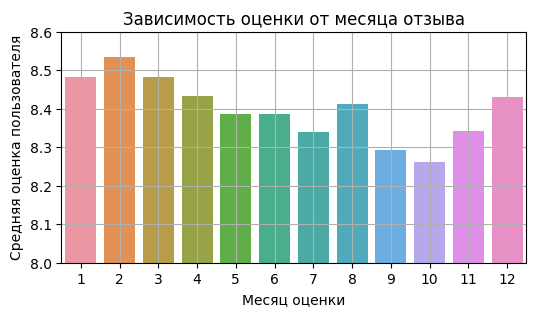

In [201]:
# 5.1 Проанализируем зависимость оценки от месяца пребывания

month_score = hotels[train_mask].groupby(hotels[train_mask]['review_date'].dt.month)['reviewer_score'].mean().reset_index() # проверим среднюю оценку от месяца

fig, axes = plt.subplots(figsize=(6, 3))

sns.barplot(month_score, 
            x=month_score['review_date'], 
            y=month_score['reviewer_score'])

axes.set(ylim=(8, 8.6))
axes.yaxis.set_ticks(np.arange(8, 8.7, 0.1));

plt.title('Зависимость оценки от месяца отзыва')
axes.yaxis.set_label_text('Средняя оценка пользователя')
axes.xaxis.set_label_text('Месяц оценки')
plt.grid()

# в теории какое-то влияние наблюдается, закодируем месяц методом OHE

In [202]:
# 5.2 Добавляем признаки месяца в датафрейм

month_df = pd.get_dummies(hotels['review_date'].dt.month)
keys = ['December', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November']
month_df.columns = keys # переименовываем столбцы для наглядности

hotels = pd.concat([hotels, month_df], axis=1)

---

In [203]:
# Примечание: Выделение города не дает повышения информативности, т.к. значения совпадают со значениям в аналогичном столбце со странами стран. Пропускаем этот шаг
display(hotels['hotel_country'].value_counts())
display(hotels['hotel_address'].apply(lambda x: x.split()[-5] if x.split()[-1] =='Kingdom' else x.split()[-2]).value_counts())

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: hotel_country, dtype: int64

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: hotel_address, dtype: int64

Text(0.5, 0, 'Средняя оценка пользователя')

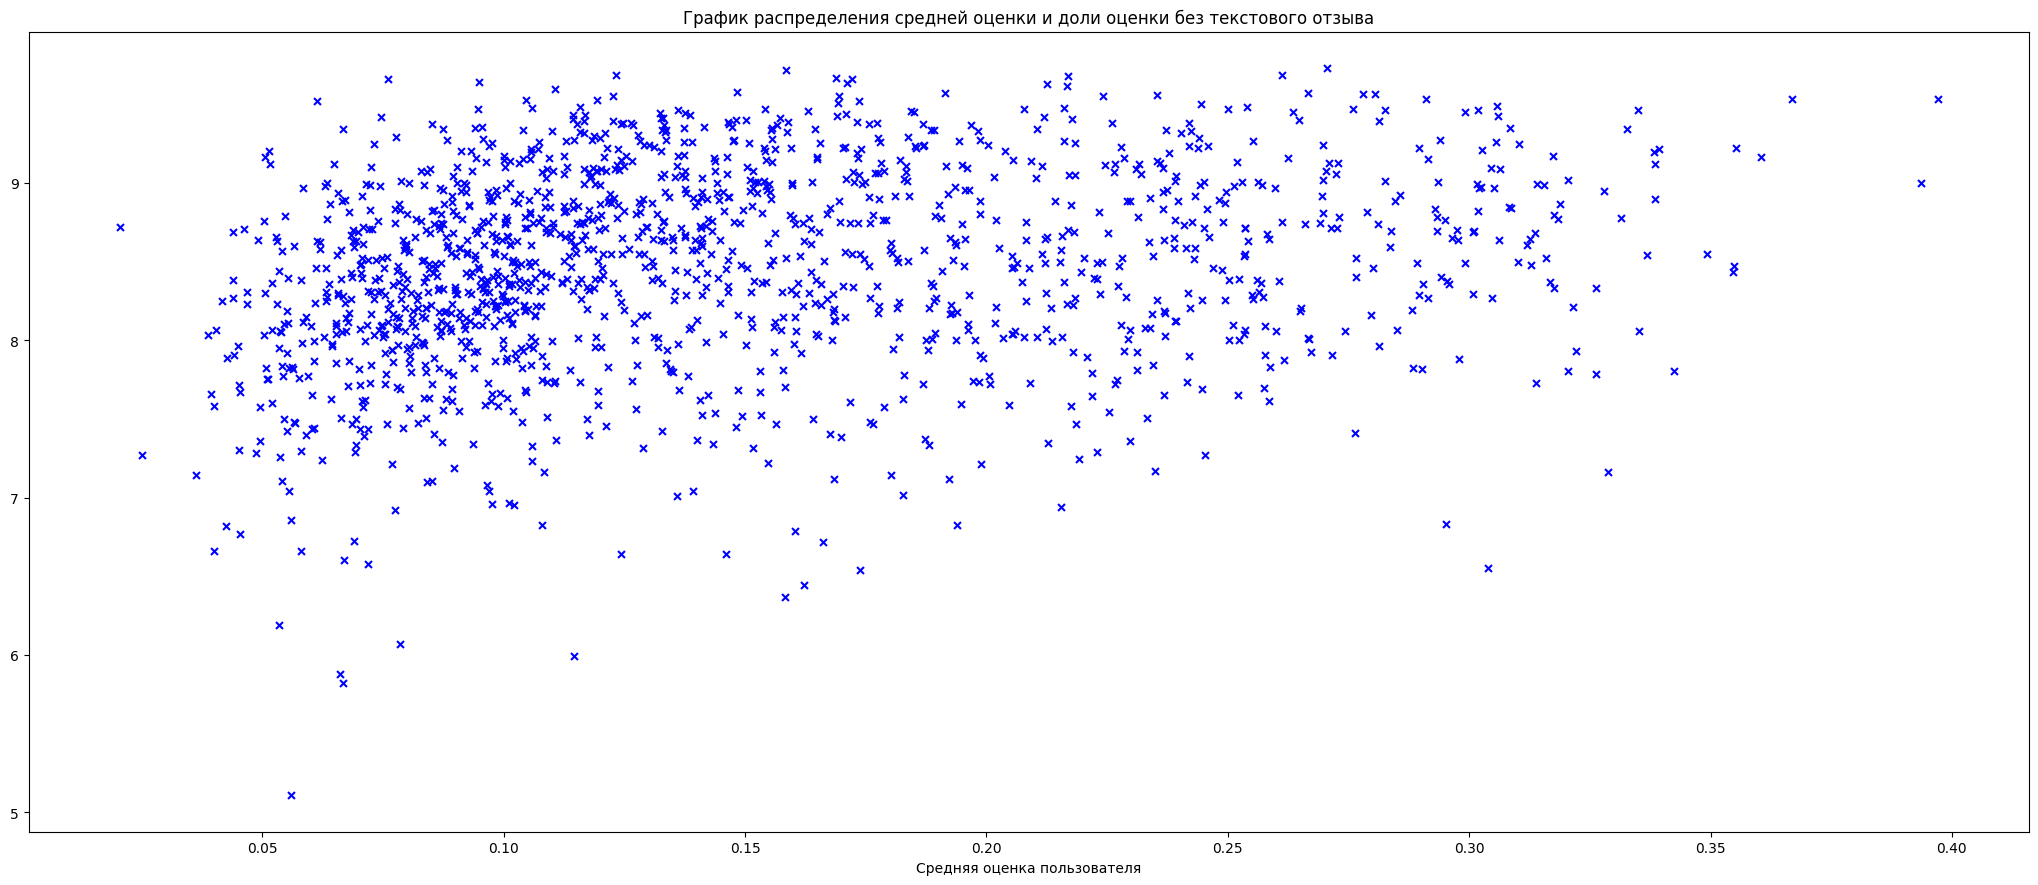

In [ ]:
# график ниже - scatterplot отношения средней оценки пользователя и доли незаполненных отзывыов. По графику не прослеживается никаких закономерностей или явного тренда, чтобы выдвинуть какую-либо гипотезу
# признак additional_number_of_scoring в дальнейшем удалим, чтобы не засорять обучение модели лишними данными
test = hotels[train_mask].groupby('hotel_name')[['total_number_of_reviews', 'additional_number_of_scoring', 'reviewer_score']].agg({'total_number_of_reviews': 'last', 
                                                                                                                        'additional_number_of_scoring' : 'last', 
                                                                                                                        'reviewer_score' : 'mean'})
                                                                                                        
test['percent'] = test['additional_number_of_scoring']/test['total_number_of_reviews']
test[['reviewer_score', 'percent']]

fig = plt.figure(figsize=(20,8)) 
axes = fig.add_axes([0,0,1,1]) 

axes.scatter(
    x=test['percent'], 
    y=test['reviewer_score'], 
    s=25, 
    marker='x', 
    c='blue',
)

plt.title('График распределения средней оценки и доли оценки без текстового отзыва')
axes.set_xlabel('Доля оценок без отзыва')
axes.set_xlabel('Средняя оценка пользователя')

---
# **Анализ корреляции и значимостиь**

In [317]:
# Cоздаем списки категориальных и непрерывных переменных. 

num_cols = ['additional_number_of_scoring', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'compound_positive', 'good_review_pos', 'good_review_neg', 'good_review_neu', 'compound_negative', 'bad_review_pos', 'bad_review_neg', 'bad_review_neu']
cat_cols = ['average_score', 'lat', 'same_country', 'Leisure trip', 'Business trip', 'Solo traveler', 'Couple', 'Family with young children', 'Group', 'Stayed 1 night', 'Stayed 2 nights', 'Stayed 3 nights', 'Stayed 4 nights', 'Stayed 5 nights', 'Stayed 6 nights', 'Stayed 7 nights', 'hotel_country_Austria', 'hotel_country_France', 'hotel_country_Italy', 'hotel_country_Netherlands', 'hotel_country_Spain', 'hotel_country_United Kingdom', 'December', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November']

Text(0.5, 1.0, 'Тепловая карта корреляции категориальных признаков')

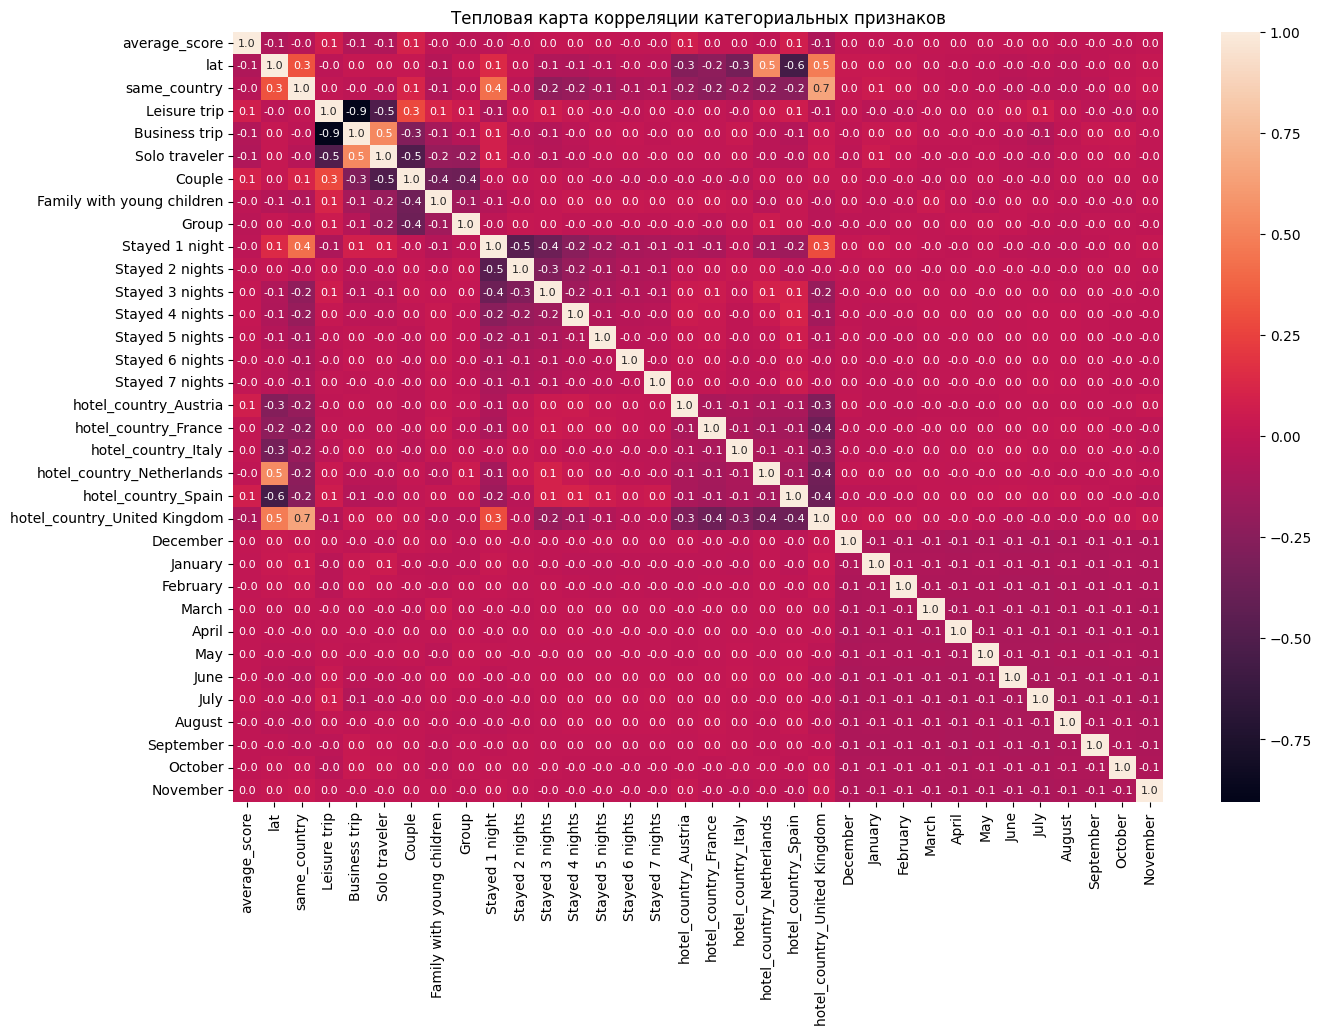

In [236]:
# Проверяем на корреляцию категориальные признаки:

fig, axes = plt.subplots(figsize=(15,10))

sns.heatmap(X[cat_cols].corr(method='spearman'), annot=True, annot_kws={"size":8}, fmt=".1f") # строим тепловую карту
plt.title('Тепловая карта корреляции категориальных признаков')

**Вывод по корреляции категориальных признаков**: по тепловой карте в категориальных признаках практически нет высоко скоррелированных, максимальный коэффициент 0.7 между признаком *same_country* И *hotel_country_United_Kingdom*, но логически они отвечают за разные показатели => удалять не будем

Text(0.5, 1.0, 'Тепловая карта корреляции неприрывных признаков')

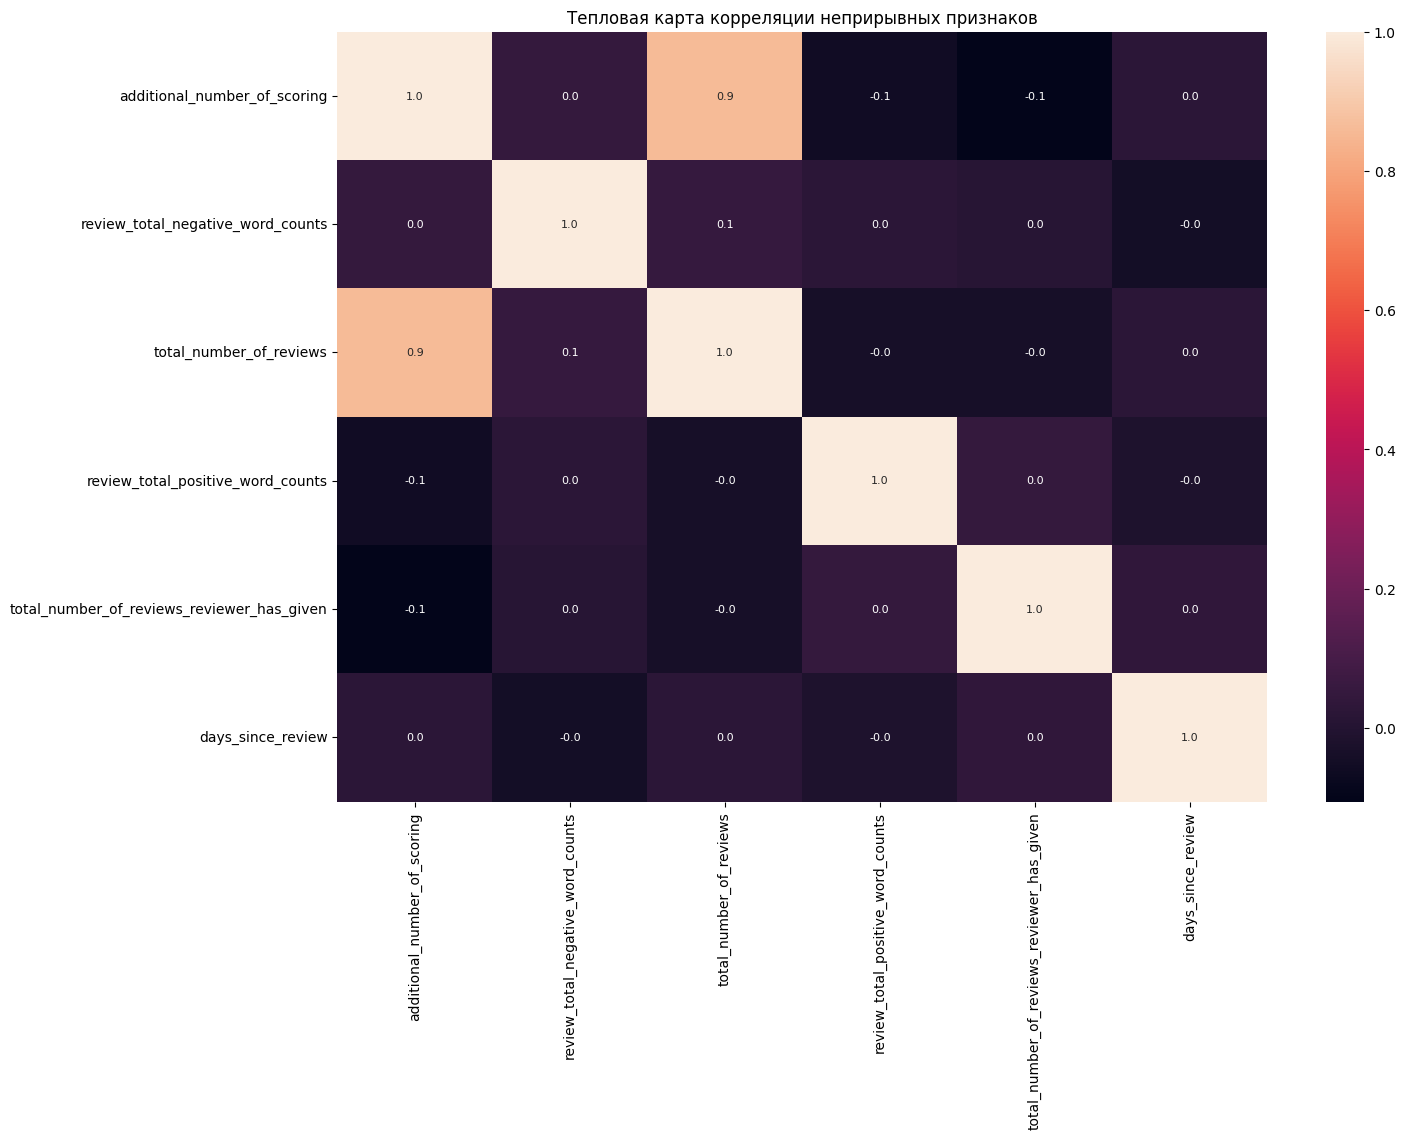

In [245]:
# Проверяем на корреляцию неприрывные признаки:

fig, axes = plt.subplots(figsize=(15,10))

sns.heatmap(hotels[num_cols].corr(method='spearman'), annot=True, annot_kws={"size":8}, fmt=".1f") # строим тепловую карту
plt.title('Тепловая карта корреляции неприрывных признаков')

**Вывод по корреляции непрерывных признаков**: по тепловой карте в непрерывных признаках скоррелированы *additional_number_of_scoring* и *total_number_of_reviews*. 

*additional_number_of_scoring* - кандидат на удаление, т.к. в дальнейшем и в тесте значимости anova он показывает низкое влияние на целевую переменную

<AxesSubplot: >

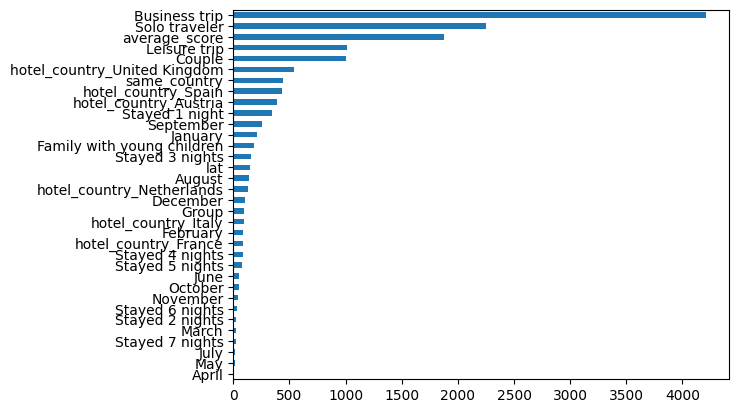

In [326]:
# тестируем значимость категориальных признаков

from sklearn.feature_selection import chi2 # хи-квадрат

y = y.astype('int')

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

**Вывод по значимости категориальных признаков**: Признаки July, May, April - оказывают минимальное влияние. Возможно, стоит их удалить

<AxesSubplot: >

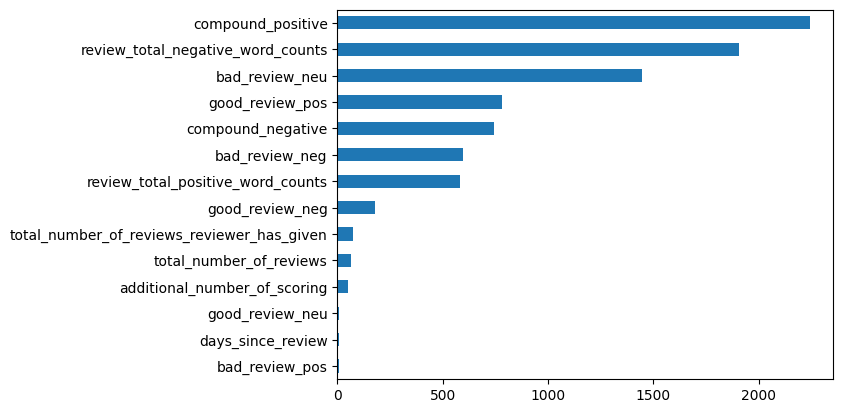

In [321]:
# тестируем значимость непрерывных признаков

from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

**Вывод по значимости непрерывных признаков**: Признаки *days_since_review* оказывает очень низкое влияние, а additional_number_of_scoring имеет высокий к корреляции с total_number_of_reviews. Возможно, стоит удалить эти 2 признака

---

# **Проектирование модели**


In [379]:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  

# Создаём объект модели
regr = RandomForestRegressor(n_estimators=100)

# удаляем столбцы с типом object и datetime
drop_cols = hotels[train_mask].select_dtypes(['object', 'datetime64']).columns
hotels_cl = hotels[train_mask].drop(drop_cols, axis=1) 

# отделяем целевой показатель от остальной выборки
X = hotels_cl.drop(['reviewer_score'], axis = 1)  
y = hotels_cl['reviewer_score']

# разделяем выборку на тренировочную и тестовую с фиксированным сидом методом train_test_split
from sklearn.model_selection import train_test_split  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Ver.1 - без изменений

In [240]:
# Для первого обучения не будем очищать модель ни от каких признаков
# Обучаем модель на тестовом наборе данных  

regr.fit(X_train, y_train) 

RandomForestRegressor()

In [241]:
# предсказываем целевую переменную
y_pred = regr.predict(X_test)

In [242]:
# оцениваем среднее абсолютное отклонение
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred)) 

MAPE: 0.12572813658788595


---

## Ver.2
Опытным путем установил, что при удалении на первый взгляд малозначимых признаков точность модели все равно падает.

Перебором вышел на то, что сочетание удаления признака additional_number_of_scoring + стандартизация 2х признаков с количеством слов в отзывах дает маржинально лучший результат

На этом этапе вряд ли получится добиться ощутимо бОльшей точности без дополнительного преобразования исходных признаков и/или создания новых

In [381]:
# удалим только столбец additional_number_of_scoring 

del_cols = ['additional_number_of_scoring']

In [380]:
# импортируем стандартизатор
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

# удаляем ненужные признаки
hotels_cl_2 = hotels_cl.drop(del_cols, axis=1)

# стандартизация признаков
hotels_cl_2[['review_total_negative_word_counts', 'review_total_positive_word_counts']] = ss.fit_transform(hotels_cl_2[['review_total_negative_word_counts', 'review_total_positive_word_counts']])

X = hotels_cl_2.drop(['reviewer_score'], axis = 1)  
y = hotels_cl_2['reviewer_score']

from sklearn.model_selection import train_test_split  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [387]:
# Заново обучаем модель на измененных входных данных v.2

regr.fit(X_train, y_train) 

RandomForestRegressor()

In [388]:
# предсказываем на переобученной модели

y_pred = regr.predict(X_test)

# оцениваем MAPE измененной модели v.2
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred)) 

MAPE: 0.12518647852771653


In [386]:
drop_cols = hotels[test_mask].select_dtypes(['object', 'datetime64']).columns
test_data = hotels[test_mask].drop(drop_cols, axis=1) 
test_data = test_data.drop(del_cols, axis=1)

test_data[['review_total_negative_word_counts', 'review_total_positive_word_counts']] = ss.fit_transform(test_data[['review_total_negative_word_counts', 'review_total_positive_word_counts']])
test_data = test_data.drop(['reviewer_score'], axis = 1)  

submit_data['reviewer_score'] = regr.predict(test_data)
submit_data.to_csv('data/submit_14.csv', index=False)

---

# **Создаем файл submission**

In [313]:
# дополнительно переобучим модель на всем датасете без разделения на train/test

regr.fit(X, y) 

RandomForestRegressor()

In [315]:
# приводим контрольный датасет к параметрам датасета, на котором проводилось обучение

drop_cols = hotels[test_mask].select_dtypes(['object', 'datetime64']).columns # удаляем не числовые признаки
test_data = hotels[test_mask].drop(drop_cols, axis=1) 

# удаляем additional_number_of_scoring и стандартизируем признаки с кол-вом слов + удаляем столбец с 0 оценками
test_data = test_data.drop(del_cols, axis=1) 
test_data[['review_total_negative_word_counts', 'review_total_positive_word_counts']] = ss.fit_transform(test_data[['review_total_negative_word_counts', 'review_total_positive_word_counts']])
test_data = test_data.drop(['reviewer_score'], axis = 1)  

# сохраняем результат и записываем в файл
submit_data['reviewer_score'] = regr.predict(test_data)
submit_data.to_csv('data/submit_14.csv', index=False)